In [2]:
!pip install einops
# main knowledge neurons class
import torch
import torch.nn.functional as F
import torch.nn as nn
import einops
from tqdm import tqdm
import numpy as np
import collections
from typing import List, Optional, Tuple, Callable

import math
from functools import partial
from transformers import PreTrainedTokenizerBase
import random
from functools import lru_cache
from functools import reduce
import operator

import json
from pathlib import Path 
import os
from glob import glob
import seaborn as sns
import pandas as pd 


from transformers import (
    BertTokenizer,
    BertLMHeadModel,
    GPT2Tokenizer,
    GPT2LMHeadModel,
)

import urllib.request
import random
random.seed(2022)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 175.2 kB/s eta 0:00:0000:0100:01


In [4]:

BERT_MODELS = ["bert-base-uncased"]
GPT2_MODELS = ["gpt2", 'gpt2-large', 'gpt2-medium']
ALL_MODELS = BERT_MODELS + GPT2_MODELS


def initialize_model_and_tokenizer(model_name: str):
    if model_name in BERT_MODELS:
        tokenizer = BertTokenizer.from_pretrained(model_name)
        model= BertLMHeadModel.from_pretrained(model_name)
    elif model_name in GPT2_MODELS:
        tokenizer = GPT2Tokenizer.from_pretrained(model_name)
        model = GPT2LMHeadModel.from_pretrained(model_name)
    else:
        raise ValueError("Model {model_name} not supported")

    model.eval()

    return model, tokenizer


def model_type(model_name: str):
    if model_name in BERT_MODELS:
        return "bert"
    elif model_name in GPT2_MODELS:
        return "gpt2"
    else:
        raise ValueError("Model {model_name} not supported")


In [5]:

PARAREL_RELATION_NAMES = [
    "P39",
    "P264", # Remove the last three patterns
    "P108",
    "P176", # Remove the last two patterns
    "P30",
    "P178", # Remove the last four patterns
    "P138", # Remove pattern 11, 12, 13
    "P47", # Remove last 4 relations / total 9
    "P27", # Remove the first one and the last pattern
    "P364", # Remove last two
    "P495",
    "P449", # Remove 4 out of 11
    "P20",
    "P36", # Remove 6 out of 14
    "P19", # Remove 6 out of 13
    "P740",
    "P279",
    "P159", # Remove 3 out of 10
    "P106", # Remove first 4 out of 11
    "P101", # Remove 3 out of 11
    "P937",
]
# Removed relations: P37, P103, P413, P1376, P1303, P530, P190, P136, P127, P1412, P407, P140,         P131, P463, P17, P1001, P361, P276


def sub_pararel(data_path: str = "datasets/pararel.json", model_type= 'bert'):
    parent_dir = Path(data_path).parent
    os.makedirs(parent_dir, exist_ok=True)
    #if os.path.exists(data_path):
        #with open(data_path, "r") as f:
            #return json.load(f)
    #else:
    PARAREL = collections.defaultdict(dict)
    # download relations from github
    for r in tqdm(PARAREL_RELATION_NAMES, "downloading pararel data"):
        with urllib.request.urlopen(
            f"https://raw.githubusercontent.com/yanaiela/pararel/main/data/pattern_data/graphs_json/{r}.jsonl"
        ) as url:
            graphs = [
                json.loads(d.strip()) for d in url.read().decode().split("\n") if d
            ]
            # Prune the punctuations
            graphs= [
                {'pattern': graph['pattern'].strip('.').strip(',').strip(), 'lemma': graph['lemma'], 
                 'extended_lemma': graph['extended_lemma'], 'tense': graph['tense'] } for graph in graphs 
            ]
            
            
            # Remove the patterns where [Y] is not at the end of the sentence
            # by manually check if [Y] is located at the end of the sentence
            graphs= [
               {'pattern': graph['pattern'], 'lemma': graph['lemma'], 
                 'extended_lemma': graph['extended_lemma'], 'tense': graph['tense'] } for graph in graphs  
                if (graph['pattern'].rindex("[Y]")+ 3== len(graph['pattern']) or graph['pattern'].rindex("[Y]")+ 4== len(graph['pattern'])) #
            ]
            
            # Manually add the punctuations back for the models for convienient in-context learning
            graphs= [
            {'pattern': graph['pattern'] if graph['pattern'][-1] in '?.,!;' else graph['pattern']+ '.', 'lemma': graph['lemma'], 
             'extended_lemma': graph['extended_lemma'], 'tense': graph['tense'] } for graph in graphs 
        ]
            

            PARAREL[r]["graphs"] = graphs
        with urllib.request.urlopen(
            f"https://raw.githubusercontent.com/yanaiela/pararel/main/data/trex_lms_vocab/{r}.jsonl"
        ) as url:
            vocab = [
                json.loads(d.strip()) for d in url.read().decode().split("\n") if d
            ]
            PARAREL[r]["vocab"] = vocab
    with open(data_path, "w") as f:
        json.dump(PARAREL, f)
    return PARAREL


def pararel_expanded(
    data_path: str = "datasets/pararel_expanded.json", obj_label_replacement=None, model_type= 'bert', instances_num= 20
):
    counter= [0 for _ in range(len(PARAREL_RELATION_NAMES))]
    parent_dir = Path(data_path).parent
    os.makedirs(parent_dir, exist_ok=True)
    #if os.path.exists(data_path):
        #with open(data_path, "r") as f:
            #return json.load(f)
    #else:
    PARAREL = sub_pararel(model_type= model_type)
    PARAREL_EXPANDED = collections.defaultdict(dict)
    # expand relations into sentences, grouped by their uui
    for key, value in tqdm(
        PARAREL.items(), "expanding pararel dataset into full sentences"
    ):
        for graph in value["graphs"]:
            for i in range(len(value["vocab"])):
            
                vocab= value["vocab"][i]
                if not PARAREL_EXPANDED.get(vocab["uuid"]):
                    if counter[PARAREL_RELATION_NAMES.index(key)]== instances_num:
                        continue
                    counter[PARAREL_RELATION_NAMES.index(key)]+= 1
                    PARAREL_EXPANDED[vocab["uuid"]] = {
                        "sentences": [],
                        "relation_name": key,
                        "obj_label": " "+ vocab["obj_label"] if not model_type== 'bert' else vocab["obj_label"],
                    }
                sentence = graph["pattern"]
                random_samples= []
                sample_vocab= []
                while len(random_samples)< 4:
                    n = random.randint(0,len(value["vocab"])- 1)
                    if n!= i and value["vocab"][n]["obj_label"]!= vocab["obj_label"] and value["vocab"][n]["obj_label"] not in sample_vocab:
                        sample_vocab.append(value["vocab"][n]["obj_label"])
                        random_samples.append(sentence.replace("[X]", value["vocab"][n]["sub_label"]).replace(
                    "[Y]", value["vocab"][n]["obj_label"])) 
                # Sample random sentences with the same structure to facilitate the in-context learning for gpt models
                
                replace= "[MASK]" if model_type== 'bert' else ''
                full_sentence = sentence.replace("[X]", vocab["sub_label"]).replace(
                    "[Y]", replace
                )
                random_samples.append(full_sentence)
                full_sentences= '\n'.join(random_samples) if model_type== 'bert' else '\n'.join(random_samples).strip('.').strip(',').strip() # Strip the punctuations for the convinience of gpt models
                
                PARAREL_EXPANDED[vocab["uuid"]]["sentences"].append(full_sentences)
    with open(data_path, "w") as f:
        json.dump(PARAREL_EXPANDED, f)
    return PARAREL_EXPANDED



In [6]:
class KnowledgeNeurons:
    def __init__(
        self,
        model: nn.Module,
        tokenizer: PreTrainedTokenizerBase,
        model_type: str = "bert",
        device: str = None,
    ):
        self.model = model
        self.model_type = model_type
        self.device = device or torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        self.model.to(self.device)
        self.tokenizer = tokenizer

        self.baseline_activations = None

        if self.model_type == "bert":
            self.transformer_layers_attr = "bert.encoder.layer"
            self.input_ff_attr = "intermediate"
            self.output_ff_attr = "output.dense.weight"
            self.word_embeddings_attr = "bert.embeddings.word_embeddings.weight"
            self.unk_token = getattr(self.tokenizer, "unk_token_id", None)
        elif "gpt2" in model_type:
            self.transformer_layers_attr = "transformer.h"
            self.input_ff_attr = "mlp.c_fc"
            self.output_ff_attr = "mlp.c_proj.weight"
            self.word_embeddings_attr = "transformer.wpe"
        else:
            raise NotImplementedError

    def _get_output_ff_layer(self, layer_idx):
        return get_ff_layer(
            self.model,
            layer_idx,
            transformer_layers_attr=self.transformer_layers_attr,
            ff_attrs=self.output_ff_attr,
        )

    def _get_input_ff_layer(self, layer_idx):
        return get_ff_layer(
            self.model,
            layer_idx,
            transformer_layers_attr=self.transformer_layers_attr,
            ff_attrs=self.input_ff_attr,
        )

    def _get_word_embeddings(self):
        return get_attributes(self.model, self.word_embeddings_attr)

    def _get_transformer_layers(self):
        return get_attributes(self.model, self.transformer_layers_attr)

    def _prepare_inputs(self, prompt, target=None, encoded_input=None):
        if encoded_input is None:
            encoded_input = self.tokenizer(prompt, return_tensors="pt").to(self.device)
        
        if target is not None:
            if "gpt2" in self.model_type:
                target = self.tokenizer.encode(" "+ target.strip())
            else:
                target = self.tokenizer.convert_tokens_to_ids(target)
        if self.model_type == "bert":
            mask_idx = torch.where(
                encoded_input["input_ids"][0] == self.tokenizer.mask_token_id
            )[0].item()
        else:
            # with autoregressive models we always want to target the last token
            mask_idx = -1
        return encoded_input, mask_idx, target

    def _generate(self, prompt, ground_truth):
        encoded_input, mask_idx, target_label = self._prepare_inputs(
            prompt, ground_truth
        )
        # for autoregressive models, we might want to generate > 1 token
        if self.model_type == "gpt2":
            n_sampling_steps = len(target_label)
        else:
            n_sampling_steps = 1  # TODO: we might want to use multiple mask tokens even with bert models

        all_gt_probs = []
        all_argmax_probs = []
        argmax_tokens = []
        argmax_completion_str = ""

        for i in range(n_sampling_steps):
            if i > 0:
                # retokenize new inputs
                encoded_input, mask_idx, target_label = self._prepare_inputs(
                    prompt, ground_truth
                )
            outputs = self.model(**encoded_input)
            probs = F.softmax(outputs.logits[:, mask_idx, :], dim=-1)
            if n_sampling_steps > 1:
                target_idx = target_label[i]
            else:
                target_idx = target_label
            gt_prob = probs[:, target_idx].item()
            all_gt_probs.append(gt_prob)

            # get info about argmax completion
            argmax_prob, argmax_id = [i.item() for i in probs.max(dim=-1)]
            argmax_tokens.append(argmax_id)
            argmax_str = self.tokenizer.decode([argmax_id])
            all_argmax_probs.append(argmax_prob)

            prompt += argmax_str
            argmax_completion_str += argmax_str

        gt_prob = reduce(operator.mul, all_gt_probs, 1) if len(all_gt_probs) > 1 else all_gt_probs[0]
        argmax_prob = (
            reduce(operator.mul, all_argmax_probs, 1)
            if len(all_argmax_probs) > 1
            else all_argmax_probs[0]
        )
        return gt_prob, argmax_prob, argmax_completion_str, argmax_tokens

    def n_layers(self):
        return len(self._get_transformer_layers())

    def intermediate_size(self):
        if self.model_type == "bert":
            return self.model.config.intermediate_size
        else:
            return self.model.config.hidden_size * 4

    @staticmethod
    def scaled_input(activations: torch.Tensor, steps: int = 20, device: str = "cpu"):
        """
        Tiles activations along the batch dimension - gradually scaling them over
        `steps` steps from 0 to their original value over the batch dimensions.
        `activations`: torch.Tensor
        original activations
        `steps`: int
        number of steps to take
        """
    
        tiled_activations = einops.repeat(activations, "b d -> (r b) d", r=steps)
        out = (
            tiled_activations
            * torch.linspace(start=0, end=1, steps=steps).to(device)[:, None]
        )
        return out

    def get_baseline_with_activations(
        self, encoded_input: dict, layer_idx: int, mask_idx: int
    ):
        """
        Gets the baseline outputs and activations for the unmodified model at a given index.
        `encoded_input`: torch.Tensor
            the inputs to the model from self.tokenizer.encode_plus()
        `layer_idx`: int
            which transformer layer to access
        `mask_idx`: int
            the position at which to get the activations (TODO: rename? with autoregressive models there's no mask, so)
        """

        def get_activations(model, layer_idx, mask_idx):
            """
            This hook function should assign the intermediate activations at a given layer / mask idx
            to the 'self.baseline_activations' variable
            """

            def hook_fn(acts):
                self.baseline_activations = acts[:, mask_idx, :]

            return register_hook(
                model,
                layer_idx=layer_idx,
                f=hook_fn,
                transformer_layers_attr=self.transformer_layers_attr,
                ff_attrs=self.input_ff_attr,
            )

        handle = get_activations(self.model, layer_idx=layer_idx, mask_idx=mask_idx)
        baseline_outputs = self.model(**encoded_input)
        handle.remove()
        baseline_activations = self.baseline_activations
        self.baseline_activations = None
        return baseline_outputs, baseline_activations

    def get_scores(
        self,
        prompt: str,
        ground_truth: str,
        batch_size: int = 10,
        steps: int = 20,
        attribution_method: str = "integrated_grads",
        pbar: bool = True,
    ):
        """
        Gets the attribution scores for a given prompt and ground truth.
        `prompt`: str
            the prompt to get the attribution scores for
        `ground_truth`: str
            the ground truth / expected output
        `batch_size`: int
            batch size
        `steps`: int
            total number of steps (per token) for the integrated gradient calculations
        `attribution_method`: str
            the method to use for getting the scores. Choose from 'integrated_grads' or 'max_activations'.
        """

        scores = []
        encoded_input = self.tokenizer(prompt, return_tensors="pt").to(self.device)
        for layer_idx in tqdm(
            range(self.n_layers()),
            desc="Getting attribution scores for each layer...",
            disable=not pbar,
        ):
            layer_scores = self.get_scores_for_layer(
                prompt,
                ground_truth,
                encoded_input=encoded_input,
                layer_idx=layer_idx,
                batch_size=batch_size,
                steps=steps,
                attribution_method=attribution_method,
            )
            scores.append(layer_scores)
        return torch.stack(scores)

    def get_coarse_neurons(
        self,
        prompt: str,
        ground_truth: str,
        batch_size: int = 10,
        steps: int = 20,
        threshold: float = None,
        adaptive_threshold: float = None,
        percentile: float = None,
        attribution_method: str = "integrated_grads",
        pbar: bool = True,
    ) -> List[List[int]]:
        """
        Finds the 'coarse' neurons for a given prompt and ground truth.
        The coarse neurons are the neurons that are most activated by a single prompt.
        We refine these by using multiple prompts that express the same 'fact'/relation in different ways.
        `prompt`: str
            the prompt to get the coarse neurons for
        `ground_truth`: str
            the ground truth / expected output
        `batch_size`: int
            batch size
        `steps`: int
            total number of steps (per token) for the integrated gradient calculations
        `threshold`: float
            `t` from the paper. If not None, then we only keep neurons with integrated grads above this threshold.
        `adaptive_threshold`: float
            Adaptively set `threshold` based on `maximum attribution score * adaptive_threshold` (in the paper, they set adaptive_threshold=0.3)
        `percentile`: float
            If not None, then we only keep neurons with integrated grads in this percentile of all integrated grads.
        `attribution_method`: str
            the method to use for getting the scores. Choose from 'integrated_grads' or 'max_activations'.
        """
        attribution_scores = self.get_scores(
            prompt,
            ground_truth,
            batch_size=batch_size,
            steps=steps,
            pbar=pbar,
            attribution_method=attribution_method,
        )
        assert (
            sum(e is not None for e in [threshold, adaptive_threshold, percentile]) == 1
        ), f"Provide one and only one of threshold / adaptive_threshold / percentile"
        if adaptive_threshold is not None:
            threshold = attribution_scores.max().item() * adaptive_threshold
        if threshold is not None:
            return torch.nonzero(attribution_scores > threshold).cpu().tolist()
        else:
            s = attribution_scores.flatten().detach().cpu().numpy()
            return (
                torch.nonzero(attribution_scores > np.percentile(s, percentile))
                .cpu()
                .tolist()
            )

    def get_refined_neurons(
        self,
        prompts: List[str],
        ground_truth: str,
        negative_examples: Optional[List[str]] = None,
        p: float = 0.5,
        batch_size: int = 10,
        steps: int = 20,
        coarse_adaptive_threshold: Optional[float] = 0.3,
        coarse_threshold: Optional[float] = None,
        coarse_percentile: Optional[float] = None,
        quiet=False,
    ) -> List[List[int]]:
        """
        Finds the 'refined' neurons for a given set of prompts and a ground truth / expected output.
        The input should be n different prompts, each expressing the same fact in different ways.
        For each prompt, we calculate the attribution scores of each intermediate neuron.
        We then set an attribution score threshold, and we keep the neurons that are above this threshold.
        Finally, considering the coarse neurons from all prompts, we set a sharing percentage threshold, p,
        and retain only neurons shared by more than p% of prompts.
        `prompts`: list of str
            the prompts to get the refined neurons for
        `ground_truth`: str
            the ground truth / expected output
        `negative_examples`: list of str
            Optionally provide a list of negative examples. Any neuron that appears in these examples will be excluded from the final results.
        `p`: float
            the threshold for the sharing percentage
        `batch_size`: int
            batch size
        `steps`: int
            total number of steps (per token) for the integrated gradient calculations
        `coarse_threshold`: float
            threshold for the coarse neurons
        `coarse_percentile`: float
            percentile for the coarse neurons
        """
        assert isinstance(
            prompts, list
        ), "Must provide a list of different prompts to get refined neurons"
        assert 0.0 <= p < 1.0, "p should be a float between 0 and 1"

        n_prompts = len(prompts)
        coarse_neurons = []
        for prompt in tqdm(
            prompts, desc="Getting coarse neurons for each prompt...", disable=quiet
        ):
            coarse_neurons.append(
                self.get_coarse_neurons(
                    prompt,
                    ground_truth,
                    batch_size=batch_size,
                    steps=steps,
                    adaptive_threshold=coarse_adaptive_threshold,
                    threshold=coarse_threshold,
                    percentile=coarse_percentile,
                    pbar=False,
                )
            )
        if negative_examples is not None:
            negative_neurons = []
            for negative_example in tqdm(
                negative_examples,
                desc="Getting coarse neurons for negative examples",
                disable=quiet,
            ):
                negative_neurons.append(
                    self.get_coarse_neurons(
                        negative_example,
                        ground_truth,
                        batch_size=batch_size,
                        steps=steps,
                        adaptive_threshold=coarse_adaptive_threshold,
                        threshold=coarse_threshold,
                        percentile=coarse_percentile,
                        pbar=False,
                    )
                )
        if not quiet:
            total_coarse_neurons = sum([len(i) for i in coarse_neurons])
            print(f"\n{total_coarse_neurons} coarse neurons found - refining")
        t = n_prompts * p
        refined_neurons = []
        c = collections.Counter()
        for neurons in coarse_neurons:
            for n in neurons:
                c[tuple(n)] += 1

        for neuron, count in c.items():
            if count > t:
                refined_neurons.append(list(neuron))

        # filter out neurons that are in the negative examples
        if negative_examples is not None:
            for neuron in negative_neurons:
                if neuron in refined_neurons:
                    refined_neurons.remove(neuron)

        total_refined_neurons = len(refined_neurons)
        if not quiet:
            print(f"{total_refined_neurons} neurons remaining after refining")
        return refined_neurons

    def get_scores_for_layer(
        self,
        prompt: str,
        ground_truth: str,
        layer_idx: int,
        batch_size: int = 10,
        steps: int = 20,
        encoded_input: Optional[int] = None,
        attribution_method: str = "integrated_grads",
    ):
        """
        get the attribution scores for a given layer
        `prompt`: str
            the prompt to get the attribution scores for
        `ground_truth`: str
            the ground truth / expected output
        `layer_idx`: int
            the layer to get the scores for
        `batch_size`: int
            batch size
        `steps`: int
            total number of steps (per token) for the integrated gradient calculations
        `encoded_input`: int
            if not None, then use this encoded input instead of getting a new one
        `attribution_method`: str
            the method to use for getting the scores. Choose from 'integrated_grads' or 'max_activations'.
        """
        assert steps % batch_size == 0
        n_batches = steps // batch_size
        
        
        # First we take the unmodified model and use a hook to return the baseline intermediate activations at our chosen target layer
        encoded_input, mask_idx, target_label = self._prepare_inputs(
            prompt, ground_truth, encoded_input
        )
        
        # for autoregressive models, we might want to generate > 1 token
        if self.model_type == "gpt2":
            n_sampling_steps = len(target_label)

        else:
            n_sampling_steps = 1
        

        if attribution_method == "integrated_grads":
            integrated_grads = []
            
            for i in range(n_sampling_steps):
                if i > 0 and self.model_type == "gpt2":
                    # retokenize new inputs
                    encoded_input, mask_idx, target_label = self._prepare_inputs(
                        prompt, ground_truth
                    )
                (
                    baseline_outputs,
                    baseline_activations,
                ) = self.get_baseline_with_activations(
                    encoded_input, layer_idx, mask_idx
                )
                if n_sampling_steps > 1:
                    
                    next_token_str = self.tokenizer.decode(target_label[i])

                # Now we want to gradually change the intermediate activations of our layer from 0 -> their original value
                # and calculate the integrated gradient of the masked position at each step
                # we do this by repeating the input across the batch dimension, multiplying the first batch by 0, the second by 0.1, etc., until we reach 1
                scaled_weights = self.scaled_input(
                    baseline_activations, steps=steps, device=self.device
                )
                scaled_weights.requires_grad_(True)

                integrated_grads_this_step = []  # to store the integrated gradients

                for batch_weights in scaled_weights.chunk(n_batches):
                    # we want to replace the intermediate activations at some layer, at the mask position, with `batch_weights`
                    # first tile the inputs to the correct batch size
                    inputs = {
                        "input_ids": einops.repeat(
                            encoded_input["input_ids"], "b d -> (r b) d", r=batch_size
                        ),
                        "attention_mask": einops.repeat(
                            encoded_input["attention_mask"],
                            "b d -> (r b) d",
                            r=batch_size,
                        ),
                    }
                    if self.model_type == "bert":
                        inputs["token_type_ids"] = einops.repeat(
                            encoded_input["token_type_ids"],
                            "b d -> (r b) d",
                            r=batch_size,
                        )

                    # then patch the model to replace the activations with the scaled activations
                    patch_ff_layer(
                        self.model,
                        layer_idx=layer_idx,
                        mask_idx=mask_idx,
                        replacement_activations=batch_weights,
                        transformer_layers_attr=self.transformer_layers_attr,
                        ff_attrs=self.input_ff_attr,
                    )

                    # then forward through the model to get the logits
                    outputs = self.model(**inputs)

                    # then calculate the gradients for each step w/r/t the inputs
                    probs = F.softmax(outputs.logits[:, mask_idx, :], dim=-1)
                    
                    if n_sampling_steps > 1:
                        target_idx = target_label[i]
                    else:
                        target_idx = target_label
                    
                    grad = torch.autograd.grad(
                        torch.unbind(probs[:, target_idx]), batch_weights
                    )[0]
                    grad = grad.sum(dim=0)
                    integrated_grads_this_step.append(grad)

                    unpatch_ff_layer(
                        self.model,
                        layer_idx=layer_idx,
                        transformer_layers_attr=self.transformer_layers_attr,
                        ff_attrs=self.input_ff_attr,
                    )

                # then sum, and multiply by W-hat / m
                integrated_grads_this_step = torch.stack(
                    integrated_grads_this_step, dim=0
                ).sum(dim=0)
                integrated_grads_this_step *= baseline_activations.squeeze(0) / steps
                integrated_grads.append(integrated_grads_this_step)

                if n_sampling_steps > 1:
                    prompt += next_token_str
            integrated_grads = torch.stack(integrated_grads, dim=0).sum(dim=0) / len(
                integrated_grads
            )
            return integrated_grads

    def modify_activations(
        self,
        prompt: str,
        ground_truth: str,
        neurons: List[List[int]],
        mode: str = "suppress",
        undo_modification: bool = True,
        quiet: bool = False,
    ) -> Tuple[dict, Callable]:
        results_dict = {}
        _, mask_idx, _ = self._prepare_inputs(
            prompt, ground_truth
        )  # just need to get the mask index for later - probably a better way to do this
        # get the baseline probabilities of the groundtruth being generated + the argmax / greedy completion before modifying the activations
        (
            gt_baseline_prob,
            argmax_baseline_prob,
            argmax_completion_str,
            _,
        ) = self._generate(prompt, ground_truth)
        if not quiet:
            print(
                f"\nBefore modification - groundtruth probability: {gt_baseline_prob}\nArgmax completion: `{argmax_completion_str}`\nArgmax prob: {argmax_baseline_prob}\n"
            )
        results_dict["before"] = {
            "gt_prob": gt_baseline_prob,
            "argmax_completion": argmax_completion_str,
            "argmax_prob": argmax_baseline_prob,
        }

        # patch model to suppress neurons
        # store all the layers we patch so we can unpatch them later
        all_layers = {n[0] for n in neurons}

        patch_ff_layer(
            self.model,
            mask_idx,
            mode=mode,
            neurons=neurons,
            transformer_layers_attr=self.transformer_layers_attr,
            ff_attrs=self.input_ff_attr,
        )

        # get the probabilities of the groundtruth being generated + the argmax / greedy completion after modifying the activations
        new_gt_prob, new_argmax_prob, new_argmax_completion_str, _ = self._generate(
            prompt, ground_truth
        )
        if not quiet:
            print(
                f"\nAfter modification - groundtruth probability: {new_gt_prob}\nArgmax completion: `{new_argmax_completion_str}`\nArgmax prob: {new_argmax_prob}\n"
            )
        results_dict["after"] = {
            "gt_prob": new_gt_prob,
            "argmax_completion": new_argmax_completion_str,
            "argmax_prob": new_argmax_prob,
        }

        unpatch_fn = partial(
            unpatch_ff_layers,
            model=self.model,
            layer_indices=all_layers,
            transformer_layers_attr=self.transformer_layers_attr,
            ff_attrs=self.input_ff_attr,
        )

        if undo_modification:
            unpatch_fn()
            unpatch_fn = lambda *args: args

        return results_dict, unpatch_fn

    def suppress_knowledge(
        self,
        prompt: str,
        ground_truth: str,
        neurons: List[List[int]],
        undo_modification: bool = True,
        quiet: bool = False,
    ) -> Tuple[dict, Callable]:
        """
        prompt the model with `prompt`, zeroing the activations at the positions specified by `neurons`,
        and measure the resulting affect on the ground truth probability.
        """
        return self.modify_activations(
            prompt=prompt,
            ground_truth=ground_truth,
            neurons=neurons,
            mode="suppress",
            undo_modification=undo_modification,
            quiet=quiet,
        )

    def enhance_knowledge(
        self,
        prompt: str,
        ground_truth: str,
        neurons: List[List[int]],
        undo_modification: bool = True,
        quiet: bool = False,
    ) -> Tuple[dict, Callable]:
        """
        prompt the model with `prompt`, multiplying the activations at the positions
        specified by `neurons` by 2, and measure the resulting affect on the ground truth probability.
        """
        return self.modify_activations(
            prompt=prompt,
            ground_truth=ground_truth,
            neurons=neurons,
            mode="enhance",
            undo_modification=undo_modification,
            quiet=quiet,
        )

    @torch.no_grad()
    def modify_weights(
        self,
        prompt: str,
        neurons: List[List[int]],
        target: str,
        mode: str = "edit",
        erase_value: str = "zero",
        undo_modification: bool = True,
        quiet: bool = False,
    ) -> Tuple[dict, Callable]:
        """
        Update the *weights* of the neural net in the positions specified by `neurons`.
        Specifically, the weights of the second Linear layer in the ff are updated by adding or subtracting the value
        of the word embeddings for `target`.
        """
        assert mode in ["edit", "erase"]
        assert erase_value in ["zero", "unk"]
        results_dict = {}

        _, _, target_label = self._prepare_inputs(prompt, target)
        # get the baseline probabilities of the target being generated + the
        # argmax / greedy completion before modifying the weights
        (
            gt_baseline_prob,
            argmax_baseline_prob,
            argmax_completion_str,
            argmax_tokens,
        ) = self._generate(prompt, target)
        if not quiet:
            print(
                f"\nBefore modification - groundtruth probability: {gt_baseline_prob}\nArgmax completion: `{argmax_completion_str}`\nArgmax prob: {argmax_baseline_prob}"
            )
        results_dict["before"] = {
            "gt_prob": gt_baseline_prob,
            "argmax_completion": argmax_completion_str,
            "argmax_prob": argmax_baseline_prob,
        }

        # get the word embedding values of the baseline + target predictions
        word_embeddings_weights = self._get_word_embeddings()
        if mode == "edit":
            # assert (
            #     self.model_type == "bert"
            # ), "edit mode currently only working for bert models - TODO"
            original_prediction_id = argmax_tokens[0]
            if self.model_type == "gpt2":
                word_embeddings_weights = word_embeddings_weights.weight
            original_prediction_embedding = word_embeddings_weights[
                original_prediction_id
            ]
            # if len(target_label) > 1:
            #     target_label = target_label[0]
            target_embedding = word_embeddings_weights[target_label]

        if erase_value == "zero":
            erase_value = 0
        else:
            assert self.model_type == "bert", "GPT models don't have an unk token"
            erase_value = word_embeddings_weights[self.unk_token]

        # modify the weights by subtracting the original prediction's word embedding
        # and adding the target embedding
        original_weight_values = []  # to reverse the action later
        for layer_idx, position in neurons:
            output_ff_weights = self._get_output_ff_layer(layer_idx)
            if self.model_type == "gpt2":
                # since gpt2 uses a conv1d layer instead of a linear layer in the ff block, the weights are in a different format
                original_weight_values.append(
                    output_ff_weights[position, :].detach().clone()
                )
            else:
                original_weight_values.append(
                    output_ff_weights[:, position].detach().clone()
                )
            if mode == "edit":
                if self.model_type == "gpt2":
                    output_ff_weights[position, :] -= original_prediction_embedding * 2
                    if target_embedding.ndim > 1:
                        for te in target_embedding:
                            output_ff_weights[position, :] += te
                    else:
                        output_ff_weights[position, :] += target_embedding * 2
                else:
                    output_ff_weights[:, position] -= original_prediction_embedding * 2
                    output_ff_weights[:, position] += target_embedding * 2
            else:
                if self.model_type == "gpt2":
                    output_ff_weights[position, :] = erase_value
                else:
                    output_ff_weights[:, position] = erase_value

        # get the probabilities of the target being generated + the argmax / greedy completion after modifying the weights
        (
            new_gt_prob,
            new_argmax_prob,
            new_argmax_completion_str,
            new_argmax_tokens,
        ) = self._generate(prompt, target)
        if not quiet:
            print(
                f"\nAfter modification - groundtruth probability: {new_gt_prob}\nArgmax completion: `{new_argmax_completion_str}`\nArgmax prob: {new_argmax_prob}"
            )
        results_dict["after"] = {
            "gt_prob": new_gt_prob,
            "argmax_completion": new_argmax_completion_str,
            "argmax_prob": new_argmax_prob,
        }

        def unpatch_fn():
            # reverse modified weights
            for idx, (layer_idx, position) in enumerate(neurons):
                output_ff_weights = self._get_output_ff_layer(layer_idx)
                if self.model_type == "gpt2":
                    output_ff_weights[position, :] = original_weight_values[idx]
                else:
                    output_ff_weights[:, position] = original_weight_values[idx]

        if undo_modification:
            unpatch_fn()
            unpatch_fn = lambda *args: args

        return results_dict, unpatch_fn


    def edit_knowledge(
        self,
        prompt: str,
        target: str,
        neurons: List[List[int]],
        undo_modification: bool = True,
        quiet: bool = False,
    ) -> Tuple[dict, Callable]:
        return self.modify_weights(
            prompt=prompt,
            neurons=neurons,
            target=target,
            mode="edit",
            undo_modification=undo_modification,
            quiet=quiet,
        )

    def erase_knowledge(
        self,
        prompt: str,
        neurons: List[List[int]],
        erase_value: str = "zero",
        target: Optional[str] = None,
        undo_modification: bool = True,
        quiet: bool = False,
    ) -> Tuple[dict, Callable]:
        return self.modify_weights(
            prompt=prompt,
            neurons=neurons,
            target=target,
            mode="erase",
            erase_value=erase_value,
            undo_modification=undo_modification,
            quiet=quiet,
        )

In [7]:


def get_attributes(x: nn.Module, attributes: str):
    """
    gets a list of period-separated attributes
    i.e get_attributes(model, 'transformer.encoder.layer')
        should return the same as model.transformer.encoder.layer
    """
    for attr in attributes.split("."):
        x = getattr(x, attr)
    return x


def set_attribute_recursive(x: nn.Module, attributes: "str", new_attribute: nn.Module):
    """
    Given a list of period-separated attributes - set the final attribute in that list to the new value
    i.e set_attribute_recursive(model, 'transformer.encoder.layer', NewLayer)
        should set the final attribute of model.transformer.encoder.layer to NewLayer
    """
    for attr in attributes.split(".")[:-1]:
        x = getattr(x, attr)
    setattr(x, attributes.split(".")[-1], new_attribute)


def get_ff_layer(
    model: nn.Module,
    layer_idx: int,
    transformer_layers_attr: str = "bert.encoder.layer",
    ff_attrs: str = "intermediate",
):
    """
    Gets the feedforward layer of a model within the transformer block
    `model`: torch.nn.Module
      a torch.nn.Module
    `layer_idx`: int
      which transformer layer to access
    `transformer_layers_attr`: str
      chain of attributes (separated by periods) that access the transformer layers within `model`.
      The transformer layers are expected to be indexable - i.e a Modulelist
    `ff_attrs`: str
      chain of attributes (separated by periods) that access the ff block within a transformer layer
    """
    transformer_layers = get_attributes(model, transformer_layers_attr)
    assert layer_idx < len(
        transformer_layers
    ), f"cannot get layer {layer_idx + 1} of a {len(transformer_layers)} layer model"
    ff_layer = get_attributes(transformer_layers[layer_idx], ff_attrs)
    return ff_layer


def register_hook(
    model: nn.Module,
    layer_idx: int,
    f: Callable,
    transformer_layers_attr: str = "bert.encoder.layer",
    ff_attrs: str = "intermediate",
):
    """
    Registers a forward hook in a pytorch transformer model that applies some function, f, to the intermediate
    activations of the transformer model.

    specify how to access the transformer layers (which are expected to be indexable - i.e a ModuleList) with transformer_layers_attr
    and how to access the ff layer with ff_attrs

    `model`: torch.nn.Module
      a torch.nn.Module
    `layer_idx`: int
      which transformer layer to access
    `f`: Callable
      a callable function that takes in the intermediate activations
    `transformer_layers_attr`: str
      chain of attributes (separated by periods) that access the transformer layers within `model`.
      The transformer layers are expected to be indexable - i.e a Modulelist
    `ff_attrs`: str
      chain of attributes (separated by periods) that access the ff block within a transformer layer
    """
    ff_layer = get_ff_layer(
        model,
        layer_idx,
        transformer_layers_attr=transformer_layers_attr,
        ff_attrs=ff_attrs,
    )

    def hook_fn(m, i, o):
        f(o)

    return ff_layer.register_forward_hook(hook_fn)


class Patch(torch.nn.Module):
    """
    Patches a torch module to replace/suppress/enhance the intermediate activations
    """

    def __init__(
        self,
        ff_layer: nn.Module,
        mask_idx: int,
        replacement_activations: torch.Tensor = None,
        target_positions: List[List[int]] = None,
        mode: str = "replace",
        enhance_value: float = 2.0,
    ):
        super().__init__()
        self.ff = ff_layer
        self.acts = replacement_activations
        self.mask_idx = mask_idx
        self.target_positions = target_positions
        self.enhance_value = enhance_value
        assert mode in ["replace", "suppress", "enhance"]
        self.mode = mode
        if self.mode == "replace":
            assert self.acts is not None
        elif self.mode in ["enhance", "suppress"]:
            assert self.target_positions is not None

    def forward(self, x: torch.Tensor):
        x = self.ff(x)
        if self.mode == "replace":
            x[:, self.mask_idx, :] = self.acts
        elif self.mode == "suppress":
            for pos in self.target_positions:
                x[:, self.mask_idx, pos] = 0.0
        elif self.mode == "enhance":
            for pos in self.target_positions:
                x[:, self.mask_idx, pos] *= self.enhance_value
        else:
            raise NotImplementedError
        return x


def patch_ff_layer(
    model: nn.Module,
    mask_idx: int,
    layer_idx: int = None,
    replacement_activations: torch.Tensor = None,
    mode: str = "replace",
    transformer_layers_attr: str = "bert.encoder.layer",
    ff_attrs: str = "intermediate",
    neurons: List[List[int]] = None,
):
    """
    replaces the ff layer at `layer_idx` with a `Patch` class - that will replace the intermediate activations at sequence position
    `mask_index` with `replacement_activations`

    `model`: nn.Module
      a torch.nn.Module [currently only works with HF Bert models]
    `layer_idx`: int
      which transformer layer to access
    `mask_idx`: int
      the index (along the sequence length) of the activation to replace.
      TODO: multiple indices
    `replacement_activations`: torch.Tensor
      activations [taken from the mask_idx position of the unmodified activations] of shape [b, d]
    `transformer_layers_attr`: str
      chain of attributes (separated by periods) that access the transformer layers within `model`.
      The transformer layers are expected to be indexable - i.e a Modulelist
    `ff_attrs`: str
      chain of attributes (separated by periods) that access the ff block within a transformer layer
    """
    transformer_layers = get_attributes(model, transformer_layers_attr)

    if mode == "replace":
        ff_layer = get_attributes(transformer_layers[layer_idx], ff_attrs)
        assert layer_idx < len(
            transformer_layers
        ), f"cannot get layer {layer_idx + 1} of a {len(transformer_layers)} layer model"

        set_attribute_recursive(
            transformer_layers[layer_idx],
            ff_attrs,
            Patch(
                ff_layer,
                mask_idx,
                replacement_activations=replacement_activations,
                mode=mode,
            ),
        )

    elif mode in ["suppress", "enhance"]:
        neurons_dict = collections.defaultdict(list)
        for neuron in neurons:
            layer_idx, pos = neuron
            neurons_dict[layer_idx].append(pos)
        for layer_idx, positions in neurons_dict.items():
            assert layer_idx < len(transformer_layers)
            ff_layer = get_attributes(transformer_layers[layer_idx], ff_attrs)
            set_attribute_recursive(
                transformer_layers[layer_idx],
                ff_attrs,
                Patch(
                    ff_layer,
                    mask_idx,
                    replacement_activations=None,
                    mode=mode,
                    target_positions=positions,
                ),
            )
    else:
        raise NotImplementedError


def unpatch_ff_layer(
    model: nn.Module,
    layer_idx: int,
    transformer_layers_attr: str = "bert.encoder.layer",
    ff_attrs: str = "intermediate",
):
    """
    Removes the `Patch` applied by `patch_ff_layer`, replacing it with its original value.

    `model`: torch.nn.Module
      a torch.nn.Module [currently only works with HF Bert models]
    `layer_idx`: int
      which transformer layer to access
    `transformer_layers_attr`: str
      chain of attributes (separated by periods) that access the transformer layers within `model`.
      The transformer layers are expected to be indexable - i.e a Modulelist
    `ff_attrs`: str
      chain of attributes (separated by periods) that access the ff block within a transformer layer
    """
    transformer_layers = get_attributes(model, transformer_layers_attr)
    assert layer_idx < len(
        transformer_layers
    ), f"cannot get layer {layer_idx + 1} of a {len(transformer_layers)} layer model"
    ff_layer = get_attributes(transformer_layers[layer_idx], ff_attrs)
    assert isinstance(ff_layer, Patch), "Can't unpatch a layer that hasn't been patched"
    set_attribute_recursive(
        transformer_layers[layer_idx],
        ff_attrs,
        ff_layer.ff,
    )


def unpatch_ff_layers(
    model: nn.Module,
    layer_indices: int,
    transformer_layers_attr: str = "bert.encoder.layer",
    ff_attrs: str = "intermediate",
):
    """
    Calls unpatch_ff_layer for all layers in layer_indices
    """
    for layer_idx in layer_indices:
        unpatch_ff_layer(model, layer_idx, transformer_layers_attr, ff_attrs)

In [8]:
RESULTS_DIR = Path('results')
os.makedirs(RESULTS_DIR, exist_ok=True)
random.seed(2022)

# load dataset
# each item in pararel is the same 'fact' (head/relation/tail) expressed in different ways
PARAREL = pararel_expanded(model_type='gpt', instances_num= 100)

##############################################################################
# data parallel stuff
NUM_REPLICAS = torch.cuda.device_count()
INDICES = list(range(len(PARAREL)))
INDICES = INDICES[0 : len(PARAREL)]
KEYS = list(PARAREL.keys())
MODEL_NAME= "gpt2"
# these are some hyperparameters for the integrated gradients step
BATCH_SIZE = 20
STEPS = 20 # number of steps in the integrated grad calculation
ADAPTIVE_THRESHOLD = 0.3 # in the paper, they find the threshold value `t` by multiplying the max attribution score by some float - this is that float.
P = 0.5 # the threshold for the sharing percentage


expanding pararel dataset into full sentences: 100%|██████████| 27/27 [00:00<00:00, 52.04it/s]


In [9]:

# setup model + tokenizer
model, tokenizer = initialize_model_and_tokenizer('gpt2')
kn = KnowledgeNeurons(model, tokenizer, model_type=model_type(MODEL_NAME))

# because we may end up getting some neurons multiple times, use lru cache to save time
@lru_cache(maxsize=None)
def get_neurons(_uuid):
    PROMPTS, GROUND_TRUTH, RELATION_NAME = (
        PARAREL[_uuid]["sentences"],
        PARAREL[_uuid]["obj_label"],
        PARAREL[_uuid]["relation_name"],
    )
    neurons = kn.get_refined_neurons(
        prompts=PROMPTS,
        ground_truth=GROUND_TRUTH.lower(),
        p=P,
        batch_size=BATCH_SIZE,
        steps=STEPS,
        coarse_adaptive_threshold=ADAPTIVE_THRESHOLD,
        quiet=True,
    )
    return neurons, PARAREL[_uuid]


def get_unrelated_fact(KEYS, uuid):
    n_keys = len(KEYS)
    while True:
        random_uuid = KEYS[random.randint(0, n_keys - 1)]
        if random_uuid == uuid:
            continue
        return random_uuid

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/718 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

In [ ]:
SUBINDICES= INDICES[0:500]

In [ ]:

# initialize results dicts
RESULTS = {}
NEURONS = {}

# go through each item in the PARAREL dataset, get the refined neurons, save them, and evaluate the results when suppressing the
# refined neurons vs. unrelated neurons.
for i, idx in enumerate(tqdm(SUBINDICES, position= 0)): # Change back to INDICES to get the full results
    uuid = KEYS[idx]
    neurons, data = get_neurons(uuid)  # get refined neurons
    #print(data['sentences'], data["obj_label"])
    unrelated_uuid = get_unrelated_fact(
        KEYS, uuid
    )  # get a uuid for an unrelated fact / relation
    unrelated_neurons, unrelated_data = get_neurons(
        unrelated_uuid
    )  # get the unrelated neurons

    # initialize a results dict
    results_this_uuid = {
        "suppression": {
            "related": {
                "pct_change": [],
                "correct_before": [],
                "correct_after": [],
                "n_prompts": len(data["sentences"]),
            },
            "unrelated": {
                "pct_change": [],
                "correct_before": [],
                "correct_after": [],
                "n_prompts": len(unrelated_data["sentences"]),
            }},
        "enhancement": {
            "related": {
                "pct_change": [],
                "correct_before": [],
                "correct_after": [],
                "n_prompts": len(data["sentences"]),
            },
            "unrelated": {
                "pct_change": [],
                "correct_before": [],
                "correct_after": [],
                "n_prompts": len(unrelated_data["sentences"]),
            }},
    }
    with torch.no_grad():
        for PROMPT in data["sentences"]:
            gt = data["obj_label"].lower()
            # really should be using a different for the suppression, but the authors didn't make their bing dataset available
            suppression_results, _ = kn.suppress_knowledge(PROMPT, gt, neurons, quiet=True)
            enhancement_results, _ = kn.enhance_knowledge(PROMPT, gt, neurons, quiet=True)

            # get the pct change in probability of the ground truth string being produced before and after suppressing knowledge
            suppression_prob_diff = (suppression_results["after"]["gt_prob"] - suppression_results["before"]["gt_prob"]) / suppression_results["before"]["gt_prob"]
            suppression_raw_diff= suppression_results["after"]["gt_prob"] - suppression_results["before"]["gt_prob"]

            results_this_uuid["suppression"]["related"]["pct_change"].append([suppression_prob_diff, suppression_raw_diff])

            enhancement_prob_diff = (enhancement_results["after"]["gt_prob"] - enhancement_results["before"]["gt_prob"]) / enhancement_results["before"]["gt_prob"]
            enhancement_raw_diff = (enhancement_results["after"]["gt_prob"] - enhancement_results["before"]["gt_prob"])
            results_this_uuid["enhancement"]["related"]["pct_change"].append([enhancement_prob_diff, enhancement_raw_diff])

            # check whether the answer was correct before/after suppression
            results_this_uuid["suppression"]["related"]["correct_before"].append(
                suppression_results["before"]["argmax_completion"] == gt
            )
            results_this_uuid["suppression"]["related"]["correct_after"].append(
                suppression_results["after"]["argmax_completion"] == gt
            )

            results_this_uuid["enhancement"]["related"]["correct_before"].append(
                enhancement_results["before"]["argmax_completion"] == gt
            )
            results_this_uuid["enhancement"]["related"]["correct_after"].append(
                enhancement_results["after"]["argmax_completion"] == gt
            )


        for PROMPT in unrelated_data["sentences"]:
            # do the same but with unrelated facts

            gt = unrelated_data["obj_label"].lower()

            unrelated_suppression_results, _ = kn.suppress_knowledge(
                PROMPT, gt, neurons, quiet=True
            )
            unrelated_enhancement_results, _ = kn.suppress_knowledge(
                PROMPT, gt, neurons, quiet=True
            )

            # get the pct change in probability of the ground truth string being produced before and after suppressing knowledge
            suppression_prob_diff = (unrelated_suppression_results["after"]["gt_prob"] - unrelated_suppression_results["before"]["gt_prob"]) / unrelated_suppression_results["before"]["gt_prob"]
            suppression_raw_diff = (unrelated_suppression_results["after"]["gt_prob"] - unrelated_suppression_results["before"]["gt_prob"]) 
            results_this_uuid["suppression"]["unrelated"]["pct_change"].append([suppression_prob_diff, suppression_raw_diff])
            enhancement_prob_diff = (unrelated_enhancement_results["after"]["gt_prob"] - unrelated_enhancement_results["before"]["gt_prob"]) / unrelated_enhancement_results["before"]["gt_prob"]
            enhancement_raw_diff = (unrelated_enhancement_results["after"]["gt_prob"] - unrelated_enhancement_results["before"]["gt_prob"]) 
            results_this_uuid["enhancement"]["unrelated"]["pct_change"].append([enhancement_prob_diff, enhancement_raw_diff])

            # check whether the answer was correct before/after suppression
            results_this_uuid["suppression"]["unrelated"]["correct_before"].append(
                unrelated_suppression_results["before"]["argmax_completion"] == gt
            )
            results_this_uuid["suppression"]["unrelated"]["correct_after"].append(
                unrelated_suppression_results["after"]["argmax_completion"] == gt
            )

            results_this_uuid["enhancement"]["unrelated"]["correct_before"].append(
                unrelated_enhancement_results["before"]["argmax_completion"] == gt
            )
            results_this_uuid["enhancement"]["unrelated"]["correct_after"].append(
                unrelated_enhancement_results["after"]["argmax_completion"] == gt
            )

    results_this_uuid["n_refined_neurons"] = len(neurons)
    results_this_uuid["n_unrelated_neurons"] = len(unrelated_neurons)
    results_this_uuid["relation_name"] = data["relation_name"]
    RESULTS[uuid] = results_this_uuid
    NEURONS[uuid] = neurons
# save results + neurons to json file
with open(RESULTS_DIR / f"{MODEL_NAME}_pararel_neurons_0.json", "w") as f:
    json.dump(NEURONS, f, indent=4)
with open(RESULTS_DIR / f"{MODEL_NAME}_pararel_results_0.json", "w") as f:
    json.dump(RESULTS, f, indent=4)

In [3]:

def format_data(results_data, key='suppression'):
    formatted = {}
    for uuid, data in results_data.items():
        if formatted.get(data["relation_name"]) is None:
            formatted[data["relation_name"]] = {"related": [], "unrelated": []}

        related_data = data[key]["related"]
        related_change = []
        for prob in related_data["pct_change"]:
            related_change.append(prob[1])

        unrelated_data = data[key]["unrelated"]
        unrelated_change = []
        for prob in unrelated_data["pct_change"]:
            unrelated_change.append(prob[1])

        if data["n_refined_neurons"] > 0 and data["n_unrelated_neurons"] > 0:
            # for some prompts we didn't get any neurons back, it would be unfair to include them
            if related_change:
                related_change = sum(related_change) / len(
                    related_change
                )
                if unrelated_change:
                    unrelated_change = sum(unrelated_change) / len(
                        unrelated_change
                    )
                else:
                    unrelated_change = 0.0
                formatted[data["relation_name"]]["related"].append(related_change)
                formatted[data["relation_name"]]["unrelated"].append(
                    unrelated_change
                )

    for relation_name, data in formatted.items():
        if data["related"]:
            data["related"] = sum(data["related"]) / len(data["related"])
        else:
            data["related"] = float("nan")
        if data["unrelated"]:
            data["unrelated"] = sum(data["unrelated"]) / len(data["unrelated"])
        else:
            data["unrelated"] = float("nan")

    pandas_format = {'relation_name': [], 'related': [], 'pct_change': []}
    for relation_name, data in formatted.items():
        verb = "Suppressing" if key == "suppression" else "Enhancing"
        pandas_format['relation_name'].append(relation_name)
        pandas_format['pct_change'].append(data['related'])
        pandas_format['related'].append(f"{verb} knowledge neurons for related facts")

        pandas_format['relation_name'].append(relation_name)
        pandas_format['pct_change'].append(data['unrelated'])
        pandas_format['related'].append(f"{verb} knowledge neurons for unrelated facts")
    return pd.DataFrame(pandas_format).dropna()


def plot_data(pd_df, experiment_type, out_path='test.png'):
    sns.set_theme(style="whitegrid")
    if experiment_type == "suppression":
        title = "Suppressing knowledge neurons"
    elif experiment_type == "enhancement":
        title = "Enhancing knowledge neurons"
    else:
        raise ValueError
    # Draw a nested barplot by species and sex
    g = sns.catplot(
        data=pd_df, kind="bar",
        x="relation_name", y="pct_change", hue="related",
        ci="sd", palette="dark", alpha=.6, height=6, aspect=4
    )
    g.despine(left=True)
    g.set_axis_labels("relation name", "Correct probability percentage change")
    g.legend.set_title(title)
    g.savefig(out_path)
    
    

In [4]:
def plot_neuron(neurons, num_of_layers= 12, out_path='neurons.png'):
    
    neur= {}
    counter= 0
    for key in neurons:
        know= neurons[key]
        for n in know:
            counter+= 1
            if n[0] in neur:
                neur[n[0]]= neur[n[0]]+ 1
            else:
                neur[n[0]]= 1
                
    lyrs= [i for i in range(num_of_layers)]
    prop= [neur.get(i, 0)/counter for i in range(num_of_layers)]


    pd_df= pd.DataFrame({'Layer': lyrs, 'Proportion': prop}, columns= ['Layer', 'Proportion'])
    sns.set_theme(style="whitegrid")
    title= "Neuron Distribution"
    g = sns.catplot(
        data=pd_df, kind="bar",
        x='Layer', y='Proportion',
    )
    g.despine(left=True)
    g.set_axis_labels("Layer index", "Neuron Proportion")
    
    g.savefig(out_path)

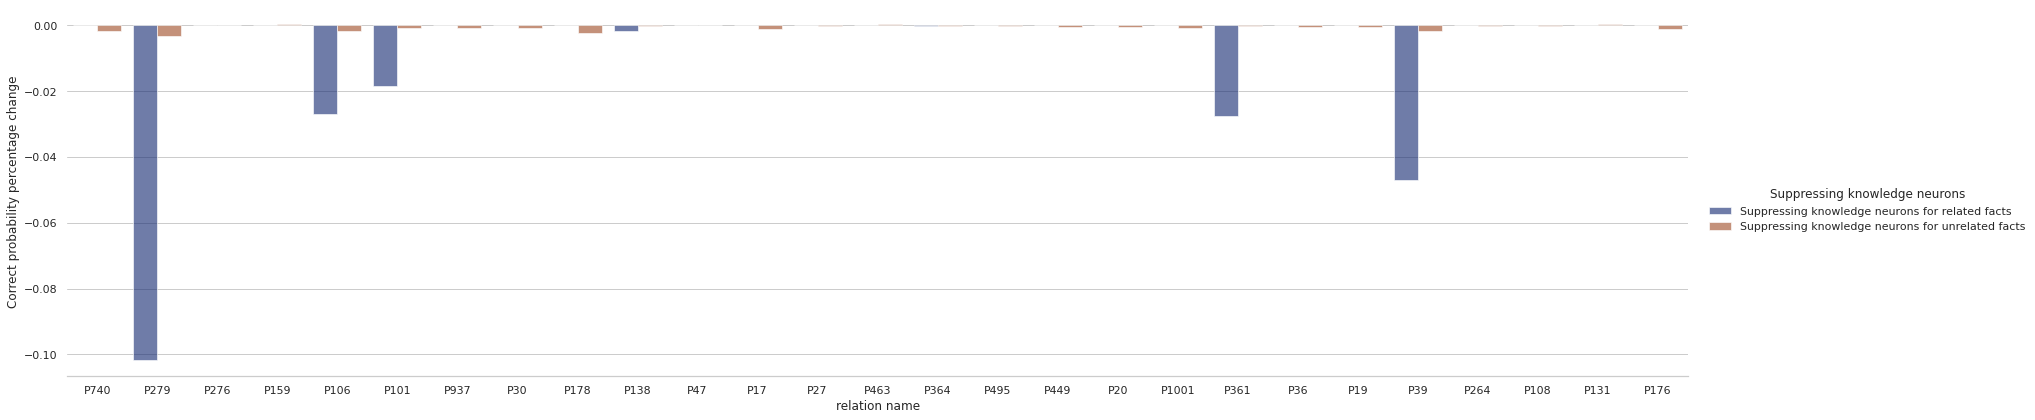

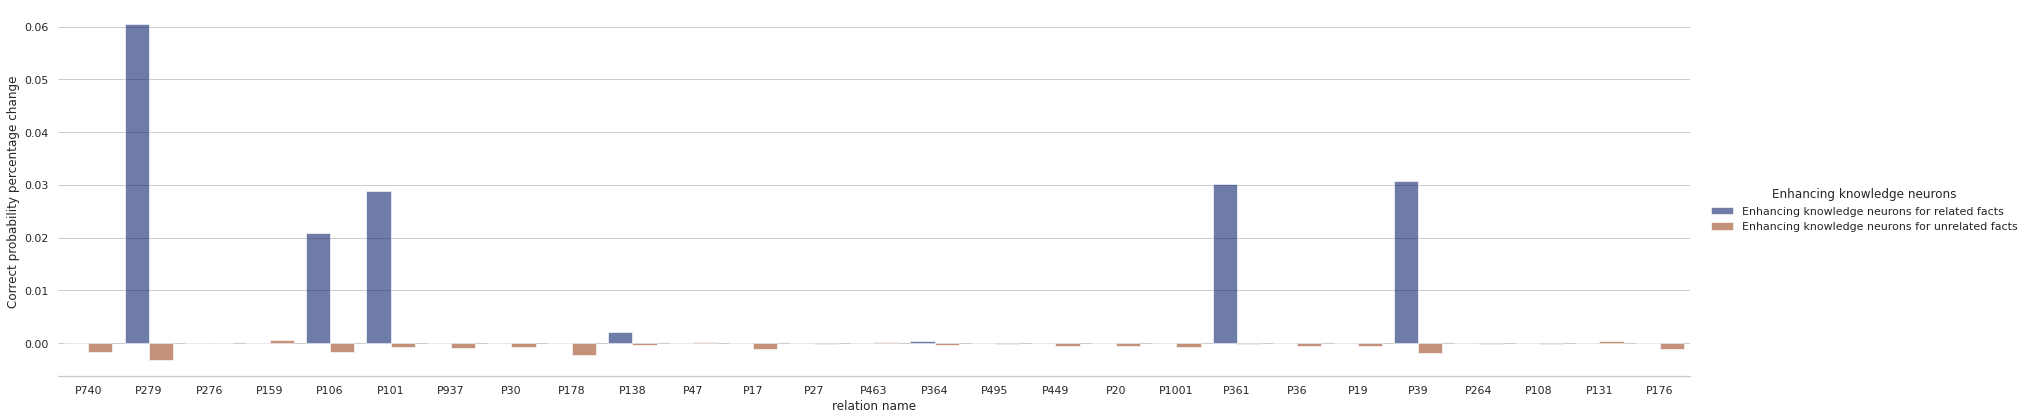

In [5]:
RESULTS_DIR= '/kaggle/input/newdata'
results_dir = Path(RESULTS_DIR)

# load results
result_paths = results_dir.glob('*results_*.json')
results = {}
for p in result_paths:
    with open(p) as f:
        results.update(json.load(f))

# plot results of suppression experiment
suppression_data = format_data(results, key='suppression')
plot_data(suppression_data, "suppression", out_path= "/kaggle/working/suppress.png")

# plot results of enhancement experiment
enhancement_data = format_data(results, key='enhancement')
plot_data(enhancement_data, "enhancement", out_path= "/kaggle/working/enhance.png")

In [6]:
RESULTS_DIR= '/kaggle/input/newdata'
results_dir = Path(RESULTS_DIR)

# load results
neurons_paths = results_dir.glob('*neurons_*.json')
neurons = {}
for p in neurons_paths:
    with open(p) as f:
        neurons.update(json.load(f))

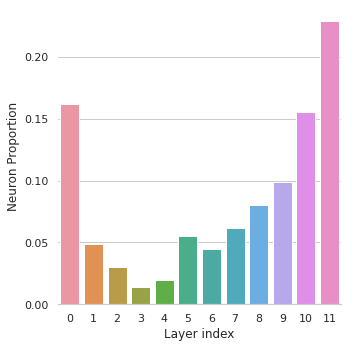

In [7]:
plot_neuron(neurons, num_of_layers= 12, out_path='neurons.png')